<img width="50" src="https://carbonplan-assets.s3.amazonaws.com/monogram/dark-small.png" style="margin-left:0px;margin-top:20px"/>

# Accessing CarbonPlan CMIP6 downscaled climate datasets

Authors: Oriana Chegwidden and Max Jones

This notebook offers users examples of accessing and working with CarbonPlan's downscaled climate datasets. The dataset collection is further described in an [explainer article](https://carbonplan.org/research/cmip6-downscaling-explainer). Monthly and annual summaries of the data products are visible in an [interactive mapping tool](https://cmip6.carbonplan.org/). We recommend using Python to interact with the datasets. Below we show examples of reading the data, performing basic analysis, and downloading subsets in space and time. We welcome further requests for interaction and encourage [feedback via GitHub](https://github.com/carbonplan/cmip6-downscaling/issues)!

In [219]:
%load_ext autoreload
%autoreload 2
%load_ext watermark
import fsspec
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import regionmask
import cartopy.crs as ccrs
from carbonplan import styles
import intake

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [66]:
from cmip6_downscaling.analysis.analysis import (
    qaqc_checks,
    grab_big_city_data,
    load_big_cities,
    get_seasonal,
    change_ds,
)
from cmip6_downscaling.analysis.plot import plot_city_data
from cmip6_downscaling.analysis.analysis import change_ds

xr.set_options(keep_attrs=True)

## Loading the data

Let's load in the catalog of datasets available in this release.

In [124]:
cat = intake.open_esm_datastore(
    'https://cmip6downscaling.blob.core.windows.net/version1/catalogs/global-downscaled-CMIP6.json'
)

We can inspect the contents according to different methods.

In [130]:
cat_subset = cat.search(method="GARD-SV")
cat_subset.df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,timescale,variable_id,method,downscaled_daily_data_uri,version
0,CMIP,BCC,BCC-CSM2-MR,historical,r1i1p1f1,day,tasmax,GARD-SV,https://cmip6downscaling.blob.core.windows.net...,v1
1,CMIP,BCC,BCC-CSM2-MR,historical,r1i1p1f1,day,tasmin,GARD-SV,https://cmip6downscaling.blob.core.windows.net...,v1
2,CMIP,CCCma,CanESM5,historical,r1i1p1f1,day,pr,GARD-SV,https://cmip6downscaling.blob.core.windows.net...,v1
3,CMIP,CCCma,CanESM5,historical,r1i1p1f1,day,tasmax,GARD-SV,https://cmip6downscaling.blob.core.windows.net...,v1
4,CMIP,CCCma,CanESM5,historical,r1i1p1f1,day,tasmin,GARD-SV,https://cmip6downscaling.blob.core.windows.net...,v1


Now let's specify what models we're interested in. We're going to select a daily maximum temperature run from the `MRI-ESM2-0` GCM and the `SSP2-4.5` future scenario, downscaled using the `GARD-MV` method.

In [141]:
cat_subset = cat.search(
    method="GARD-MV", source_id="MRI-ESM2-0", experiment_id="ssp245", variable_id="tasmax"
)

In [142]:
dsets = cat_subset.to_dataset_dict()
dsets


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.timescale.method'


{'ScenarioMIP.MRI.MRI-ESM2-0.ssp245.day.GARD-MV': <xarray.Dataset>
 Dimensions:    (lat: 721, lon: 1440, member_id: 1, time: 31046)
 Coordinates:
   * lat        (lat) float32 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
   * lon        (lon) float32 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
   * time       (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2099-12-31
   * member_id  (member_id) <U8 'r1i1p1f1'
 Data variables:
     tasmax     (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 31046, 48, 48), meta=np.ndarray>
 Attributes:
     history:                 Created: Tue Jun 28 06:08:02 2022
     hostname:                jupyter-norlandrhagen--prod-5f2-5fhuge
     institution:             CarbonPlan
     source:                  /srv/conda/envs/notebook/bin/prefect
     title:                   gard_fit_and_predict
     username:                norlandrhagen
     version:                 0.1.9.post23
     intake_esm_varname:      ['tasmax']
     intake_es

And now let's load that dataset into the notebook.

In [121]:
ds = dsets['ScenarioMIP.MRI.MRI-ESM2-0.ssp245.day.GARD-MV']

## Visualizing the data

The temperature data are in units of Kelvin. Let's convert to Celcius to make it easer to interpret.

In [122]:
ds -= 273.15

### Plotting maps

Let's load in a land mask and a projection for mapping.

In [143]:
land = regionmask.defined_regions.natural_earth_v5_0_0.land_110
projection = ccrs.PlateCarree()

We'll mask out the ocean values and load data for a single timestep (August 1, 2022) and a region of interest. We'll start with the East Africa region we reference in Figure 1 of the companion web article.

In [163]:
east_africa_region = {'lat': slice(-3, 17), 'lon': slice(17, 57)}
east_africa_tasmax = ds.tasmax.sel(time="2089-08-01").sel(**east_africa_region).load()
east_africa_tasmax = east_africa_tasmax.where(land.mask(east_africa_tasmax) == 0)

And now let's plot that single timeslice

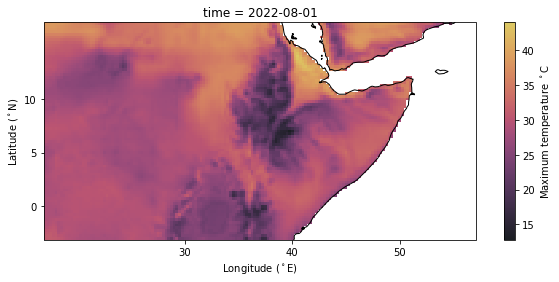

In [168]:
fig, ax = plt.subplots(subplot_kw=dict(projection=projection), figsize=(10, 4))
tasmax.plot(
    cbar_kwargs=dict(label="Maximum temperature $^\circ$C"),
    cmap='warm_dark',
)
ax.coastlines()
ax.set_xticks([30, 40, 50], crs=projection)
ax.set_xlabel('Longitude ($^\circ$E)')
ax.set_yticks([0, 5, 10], crs=projection)
ax.set_ylabel('Latitude ($^\circ$N)')
plt.show()

Now let's do the same thing but for the whole globe. And while we're at it, let's grab the annual mean temperatures of that daily data for a 30 year period at the end of the century (the "2080s"). Caution - this could take a while (i.e., minutes)- it's a lot of data! We'll define two timeslices (we'll use the second one later in the notebook).

In [154]:
time_slices = {'2030s': slice('2020', '2049'), '2080s': slice('2070', '2099')}

In [155]:
# Calculate the 30-year mean bracketing the 2080s.
tasmax_2080s = ds.tasmax.sel(time=time_slices['2080s']).mean(dim='time').load()
# mask as above
tasmax_2080s = tasmax_2080s.where(land.mask(tasmax_2080s) == 0).load()

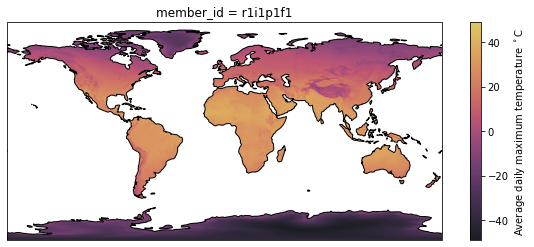

In [169]:
fig, ax = plt.subplots(subplot_kw=dict(projection=projection), figsize=(10, 4))
tasmax_2080s.plot(
    cbar_kwargs=dict(label="Mean daily maximum temperature $^\circ$C"), cmap='warm_dark'
)
ax.coastlines()
plt.show()

### Plotting timeseries

Let's look at the data at some individual points! After all, one of the main goals of downscaling is to provide more local information. We'll grab timeseries from 50 big cities around the world to explore what climate change might look like for them.

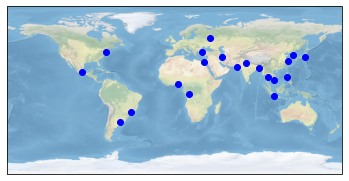

In [177]:
big_cities = load_big_cities(num_cities=20, add_additional_cities=False, plot=True)

In [178]:
[downscaled_cities] = grab_big_city_data([ds], big_cities)

Let's plot a timeseries of the daily data at just one of those 50 cities. Let's look at Tokyo.

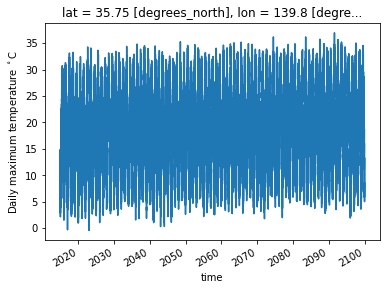

In [186]:
downscaled_cities.sel(cities='Tokyo').tasmax.plot()
plt.ylabel("Daily maximum temperature $^\circ$C")
plt.show()

That's a lot of daily data though- we can make it clearer by summarizing it into a seasonal cycle. Let's comparing 30 year periods near the start and end of the 21st century to see this model's projection of changes in temperature at this location.

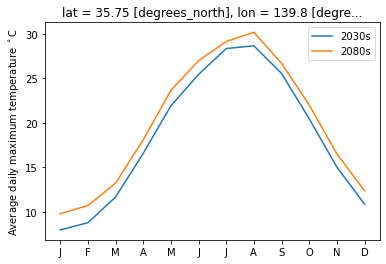

In [183]:
fig, ax = plt.subplots()
for label, time_slice in time_slices.items():
    ts.sel(time=time_slice).groupby('time.month').mean().plot(label=label)
ax.set_xticks(np.arange(1, 13))
ax.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
plt.legend()
plt.ylabel("Mean daily maximum temperature $^\circ$C")
plt.xlabel('')
plt.show()

Now let's do that for all of the cities we grabbed to get a sense of how popualtion centers around the world will fare.

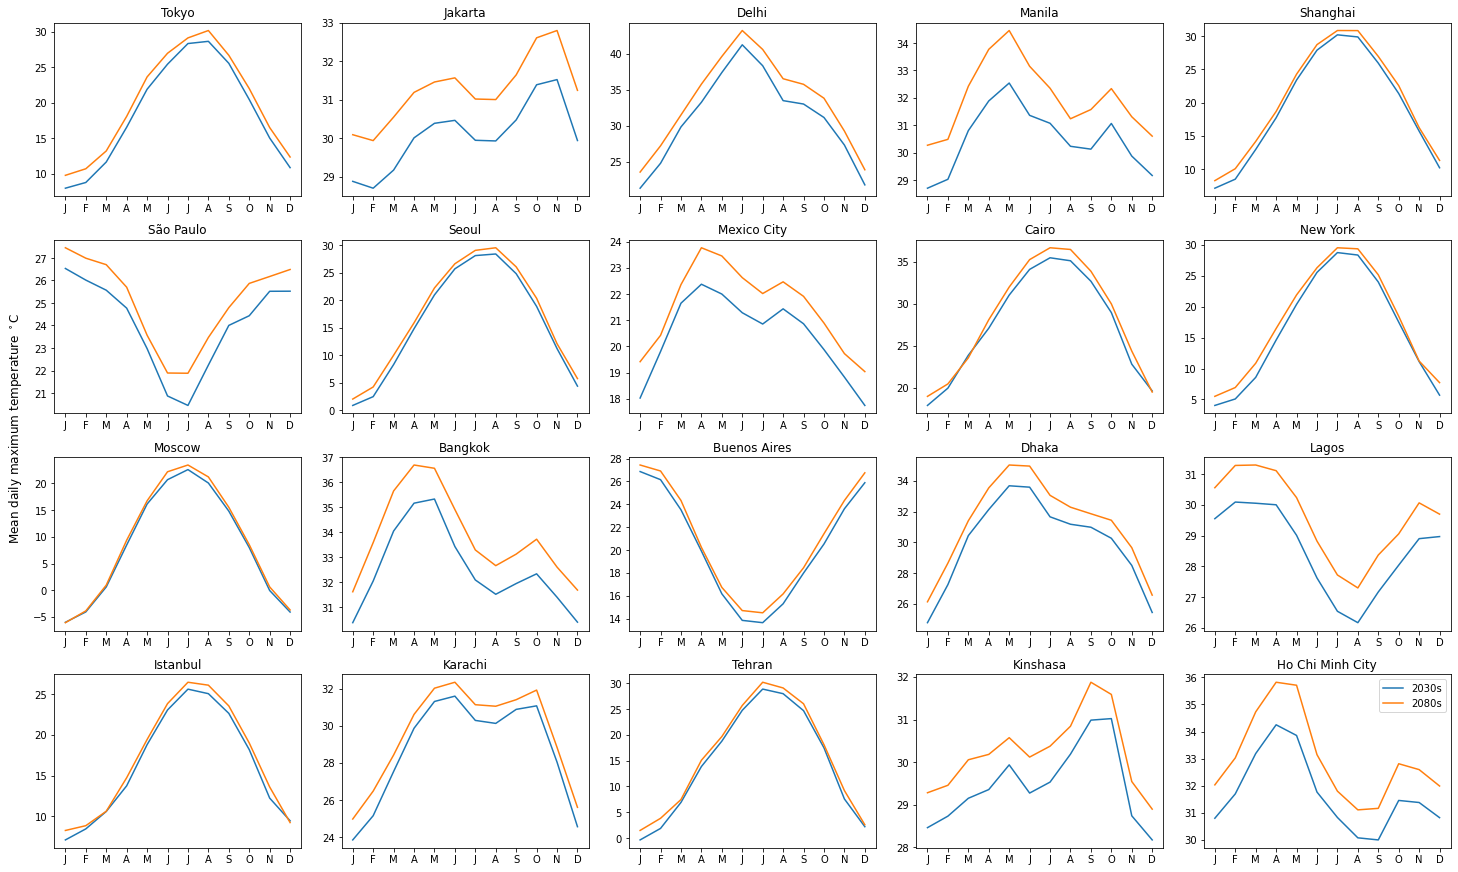

In [196]:
plot_city_data(
    downscaled_cities.tasmax,
    time_slices=time_slices,
    aggregation='seasonal_cycle',
    ylabel="Mean daily maximum temperature $^\circ$C",
)

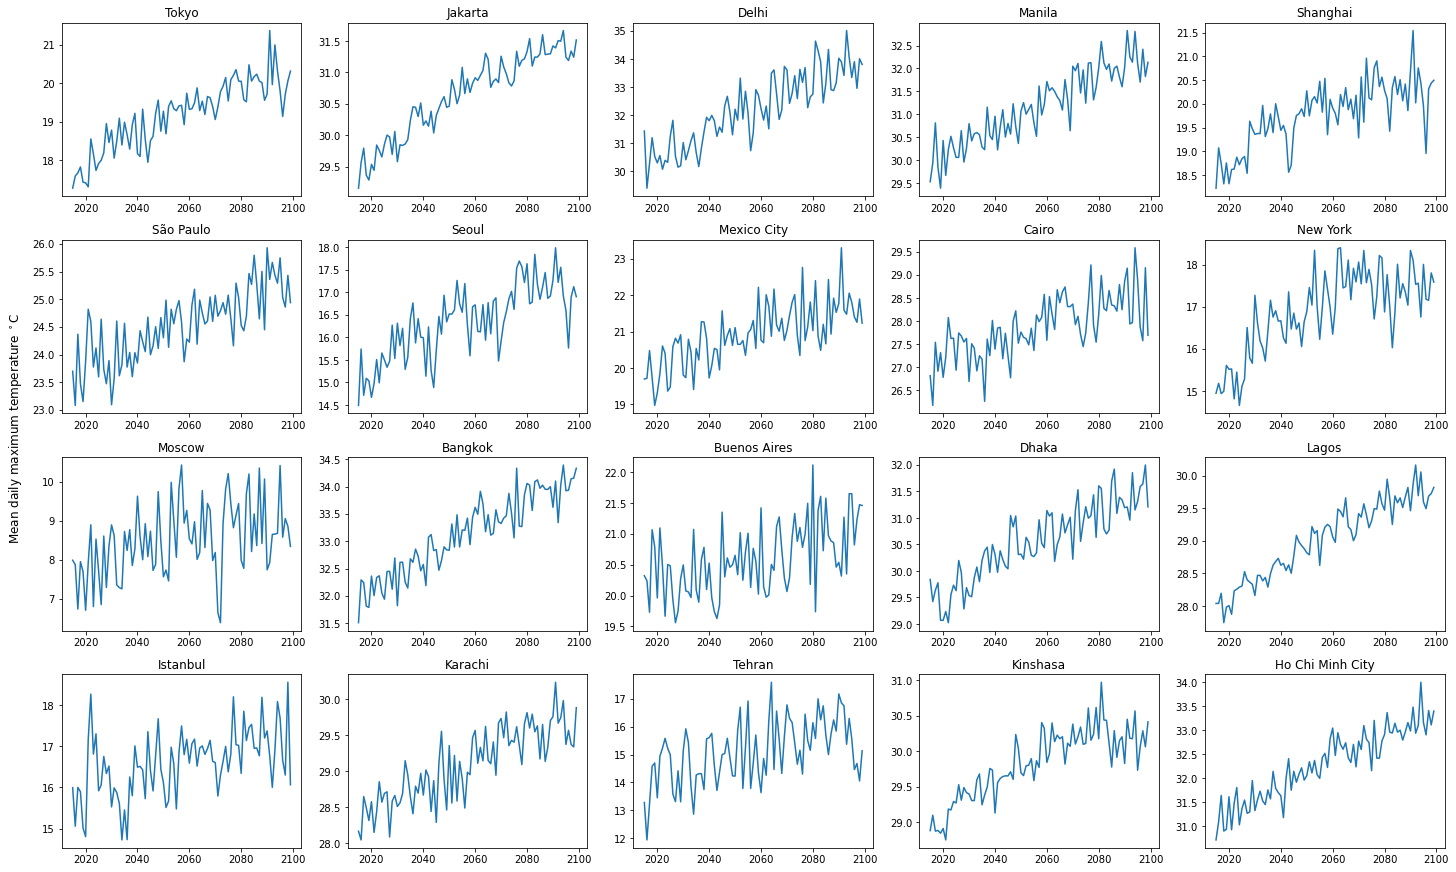

In [195]:
plot_city_data(
    downscaled_cities.tasmax,
    aggregation='annual',
    ylabel="Mean daily maximum temperature $^\circ$C",
)

## Downloading the data

And now let's download one of these daily timeseries to work with on our own computer.

In [212]:
ts.to_dataframe().reset_index().drop(columns=['member_id', 'cities', 'lat', 'lon']).to_csv(
    'tokyo.csv'
)

We can also download a small regional subset as a netcdf file locally. Note that this might be quite large. We'll first check out how big it is.

In [213]:
print('Dataset is {} GB'.format(ds.sel(**east_africa_region).nbytes * 1e-9))

Dataset is 1.6197329120000001 GB


If you want to save it locally switch the flag to `True`.

In [214]:
save_subset = False
if save_subset:
    ds.sel(**east_africa_region).to_netcdf('region.nc')

### Environment information

In case you run into any Python package or computing environment issues, execute the command below. Compare the output of the command below with the output from our notebook on Github. Any differences should give you pointers toward missing packages.

In [228]:
watermark - d - n - t - u - v - h - m - r - -iversions

Last updated: 2022-06-30 21:46:28

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.4.0

Compiler    : GCC 10.3.0
OS          : Linux
Release     : 5.4.0-1062-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

Hostname: jupyter-orianac

Git repo: https://github.com/carbonplan/cmip6-downscaling.git

regionmask: 0.9.0
matplotlib: 3.5.2
xarray    : 2022.6.0rc0
cartopy   : 0.20.2
intake    : 0.6.5
numpy     : 1.22.4
fsspec    : 2022.5.0
carbonplan: 0.5.0

